In [268]:
# Function definitions for the analysis

import numpy as np
import math
import sklearn.decomposition as sk
import seaborn as sns
sns.set_style("whitegrid")
sns.reset_orig()
import warnings
warnings.filterwarnings('ignore')
from scipy.special import gammainc
from scipy.special import lambertw
from scipy import stats
from matplotlib import pyplot as plt
import scipy.io

import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import time

def histc(X, bins):

    map_to_bins = np.digitize(X,bins)
    r = np.zeros((len(X[0,:]),len(bins)))
    for j in range(len(map_to_bins[0,:])):
        for i in map_to_bins[:,j]:
            r[j,i-1] += 1
    return [r, map_to_bins]

def randsphere(n_points,ndim,radius):
    center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def preprocessing(X,center,dimred,whiten,projectonsphere,eigval_retaining_factor = 10):
    Xp = X
    #centering
    nobjects = len(X[:,0])
    sampleMean = np.mean(X,axis=0)
    if center:
        Xp = X-sampleMean
    #dimension reduction
    PCAcomputed = 0
    if dimred or whiten:
        pca = sk.PCA()
        u = pca.fit_transform(Xp)
        v = pca.components_.T
        s = pca.explained_variance_
        PCAcomputed = 1
        sc = s/s[0]
        ind = np.where(sc > 1/eigval_retaining_factor)[0]
        Xp = Xp@v[:,ind]
        print('%i components are retained using factor %2.2f' %(len(ind),eigval_retaining_factor))
    #whitening
    if whiten:
        Xp = u[:,ind]
        st = np.std(Xp,ddof=1)
        Xp = Xp/np.tile(st,(nobjects,1))
    #project on sphere (scale each vector to unit length)
    if projectonsphere:
        st = np.sqrt(np.sum(Xp**2,axis=1))
        st = np.array([st]).T
        Xp = Xp/(np.tile(st,(1,len(Xp[0,:]))))
    
    return Xp        

def probability_unseparable_sphere(alpha,n):
    p = np.power((1-alpha*alpha),(n-1)/2)/(alpha*np.sqrt(2*math.pi*n))
    return p

def checkSeparability(xy,alpha):
    dxy = np.diag(xy)
    sm = (xy/dxy).T
    sm = sm - np.diag(np.diag(sm))
    sm = sm>alpha
    py = sum(sm.T)
    py = py/len(py[0,:])
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def checkSeparabilityMultipleAlpha(xy,alpha):

    dxy = np.diag(xy)
    sm = (xy/dxy).T


    if len(alpha[:,0])>1:
        alpha = alpha.T
    addedone = 0
    if max(alpha[0,:])<1:
        alpha = np.array([np.append(alpha,1)])
        addedone = 1

    alpha = np.concatenate([[float('-inf')],alpha[0,:], [float('inf')]])

    sm = sm - np.diag(np.diag(sm))
    
#     sm = scipy.io.loadmat('sm.mat')['sm']

    [counts,binMap] = histc(sm.T,alpha)
    
    na=len(alpha)
    
    for i in range(na-1): 
        counts[:,na-i-2]=counts[:,na-i-2]+counts[:,na-i-1]
    
    py = counts/len(sm[:,0])
    py = py.T
    if addedone:
        py = py[1:-2,:]
    else:
        py = py[1:-1,:]
    
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def dimension_uniform_sphere(py,alpha,number_of_data_points):

    if len(py)!=len(alpha[0,:]):
        print('ERROR: length of py (%i) and alpha (%i) does not match'%(len(py),len(alpha[0,:])))
        return
    
    n = np.zeros((len(alpha[0,:])))
    for i in range(len(alpha[0,:])):
        if alpha[0,i]>=1:
            print('ERROR: alpha is >=1')
            return 
        if alpha[0,i]<=0:   
            print('ERROR: alpha is <=0')
            return
        else:
            p  = py[i]
            a  = alpha[0,i]
            a2 = alpha[0,i]**2
            n[i] = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
 
    n[n==np.inf]= float('nan')
    inds = np.where(~np.isnan(n))[0]
    alpha_max = max(alpha[0,inds])
    alpha_ref = alpha_max*0.9
    k = np.where(abs(alpha[0,inds]-alpha_ref)==min(abs(alpha[0,:]-alpha_ref)))[0]
    alfa_single_estimate = alpha[0,inds[k]]
    p = py[inds[k]]
    a = alfa_single_estimate
    a2 = alfa_single_estimate**2 
    n_single_estimate = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
    
    return n,n_single_estimate,alfa_single_estimate

def SeparabilityAnalysis(X,ColinearityControl=10,ProjectOnSphere = 1,alphas = np.array([np.arange(.6,1,.02)]),ProducePlots = 1):
    
    Xp = preprocessing(X,1,1,1,ProjectOnSphere,eigval_retaining_factor=ColinearityControl)
    xy = Xp@Xp.T
    npoints = len(X[:,0])
#     xy = scipy.io.loadmat('xy.mat')['xy']
    [separable_fraction,p_alpha] = checkSeparabilityMultipleAlpha(xy,alphas)
    py_mean = np.mean(p_alpha,axis=1)
    
    [n_alpha,n_single,alpha_single] = dimension_uniform_sphere(py_mean,alphas,npoints)

    alpha_ind_selected = np.where(n_single==n_alpha)[0]
    
    if ProducePlots:
        
        n_min = np.floor(min(n_alpha));
        n_max = np.floor(max(n_alpha)+0.8);
        if n_min==0:
            n_min = 1
        if n_min>1:
            n_min = n_min-1
        if n_min>1:
            n_min = n_min-1

        n_max = n_max+2
        ns = np.arange(n_min,n_max)
        
        plt.figure()
        plt.plot(alphas[0,:],n_alpha,'ko-');plt.plot(alphas[0,alpha_ind_selected],n_single,'rx',markersize=16)
        plt.xlabel('Alpha'); plt.ylabel('Effective dimension') ; plt.show()
        nbins = int(round(np.floor(npoints/200)))

        if nbins<20:
            nbins = 20
            
        plt.figure()
        plt.hist(p_alpha[alpha_ind_selected,:][0],bins=nbins)
        plt.xlabel('unseparability prob.p for alpha=%2.2f'%(alphas[0,alpha_ind_selected])); plt.ylabel('Number of values');plt.show()
                
        plt.figure()
        plt.semilogy(alphas[0,:],py_mean,'bo-','LineWidth',3);
        plt.xlabel('Alpha'); plt.ylabel('Mean unseparability prob.');
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))

        pteor = np.zeros((len(ns),len(alphas[0,:])))
        for k in range(len(ns)):
            for j in range(len(alphas[0,:])):
                pteor[k,j] = probability_unseparable_sphere(alphas[0,j],ns[k])

        for i in range(len(pteor[:,0])):
            plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1); plt.show()


    return n_alpha,n_single,p_alpha,alphas,separable_fraction

def ismember(A, B):
    return [ B[a] for a in A ]

def list2dict(lst):
    dct = {}
    for s,i in enumerate(lst):
        dct[i] = s
    return dct


<class 'numpy.ndarray'>


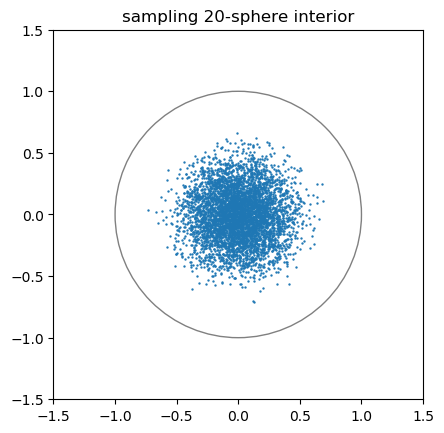

(5000, 20)
20 components are retained using factor 10.00


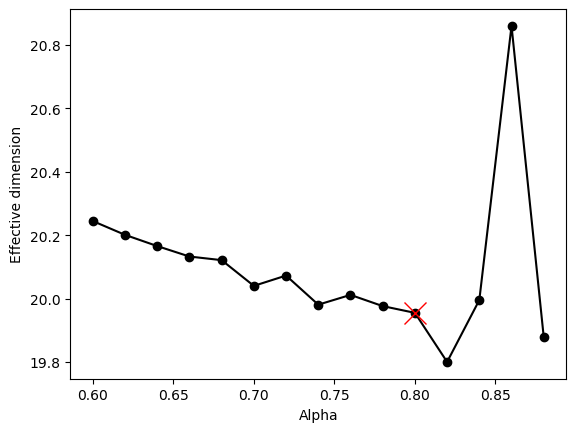

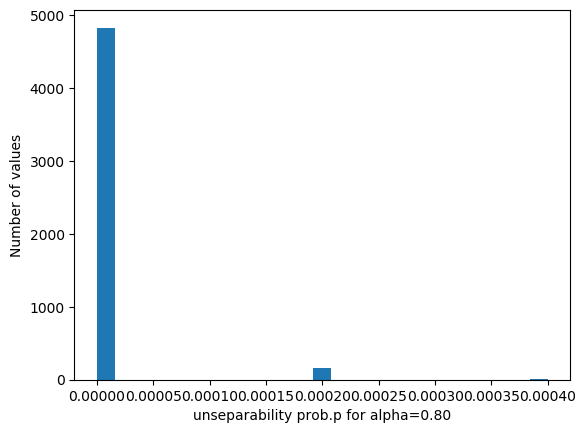

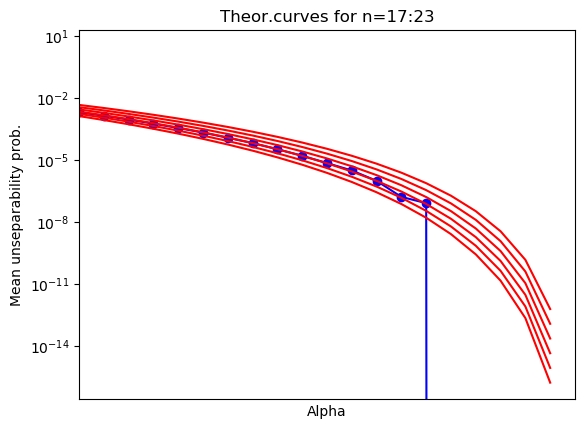

In [297]:
# Simplest test - uniform distribution of k points on a N-dimensional sphere, determining N from the distribution

fig1 = plt.figure()
ax1 = fig1.gca()
npoints = 5000
dimension = 20
radius = 1
X,center = randsphere(npoints,dimension,radius)
print(type(X))
ax1.scatter(X[:,0],X[:,1],s=0.5)
ax1.add_artist(plt.Circle(center,radius,fill=False,color='0.5'))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax1.set_aspect('equal')
ax1.set_title('sampling %i-sphere interior'%dimension)
plt.show()

print(X.shape)
[n_alpha,n_single,p_alpha,alphas,separable_fraction] = SeparabilityAnalysis(X)

In [215]:
# Work with BCNN data, loading a dataset

folder = 'C:/Datas/Kharchenko_BCNN/'
file = 'Sst.txt'
df = pd.read_csv(folder+'bytype/'+file,sep='\t')
#print(df)
dft = df.transpose()
#print(dft)
list_of_samples = df.columns[1:-1].to_list()
print('Number of samples = {}'.format(len(list_of_samples)))

#x = df.to_numpy()[:,1:]
# this is to treat an artefact of last empty column if needed
x = df.to_numpy()[:,1:-1]

x = x.T
print(x.shape)
print(x)

annot_file = 'clusterings5.txt'
annot_df = pd.read_csv(folder+annot_file,sep='\t')
print(annot_df)
samplesAnn = annot_df['SAMPLE'].tolist()
print('Number of samples = {}'.format(len(samplesAnn)))
samplesAnnDict = list2dict(samplesAnn)

irx = ismember(list_of_samples,samplesAnnDict)
clusters =  annot_df.loc[irx,'CLUSTER'].tolist()
unique_clusters = list(set(clusters))

cluster_counts = []
for s in unique_clusters:
    cluster_counts.append(clusters.count(s))
for i,s in enumerate(unique_clusters):
    print(str(s)+' {}'.format(cluster_counts[i]))



Number of samples = 2335
(2335, 50)
[[23.041 1.909 1.547 ... -2.369 1.89 6.86]
 [19.537 0.7609999999999999 0.426 ... -0.98 0.807 3.366]
 [18.512 2.0540000000000003 -0.5 ... -2.33 -0.6709999999999999 2.785]
 ...
 [22.570999999999998 -2.4819999999999998 0.479 ... 1.7369999999999999
  2.76 -12.773]
 [23.78 -2.767 1.79 ... 2.633 0.795 -10.538]
 [23.485 -2.3480000000000003 -0.267 ... 1.3730000000000002 2.032 -9.7]]
                                     SAMPLE  CLUSTER
0      AAACCTGAGGGCTCTC-4L8TX_171026_01_F04        3
1      AAACCTGCAAGGACAC-4L8TX_171026_01_F04        1
2      AAACCTGCAATTCCTT-4L8TX_171026_01_F04       59
3      AAACCTGCAGTCGATT-4L8TX_171026_01_F04       40
4      AAACCTGCATGTAAGA-4L8TX_171026_01_F04       49
...                                     ...      ...
35830  TTTGTCATCACGGTTA-8L8TX_171026_01_A05       28
35831  TTTGTCATCGGTCTAA-8L8TX_171026_01_A05        6
35832  TTTGTCATCTCCCTGA-8L8TX_171026_01_A05       20
35833  TTTGTCATCTGAGTGT-8L8TX_171026_01_A05       44
358

Computing PCA...
(2335, 50)
 Elapsed time 0.02 s


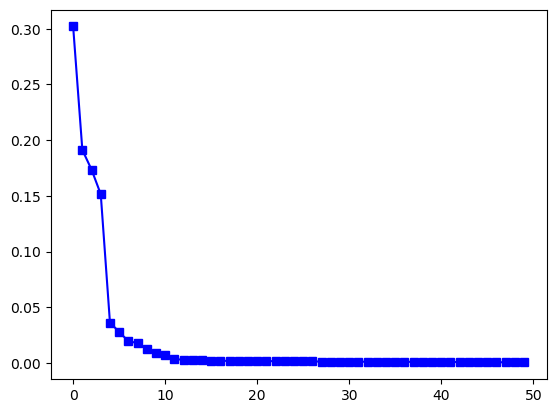

In [216]:
# Work with BCNN data, computing PCA

pca = PCA()
print('Computing PCA...')
start_time = time.time()
pcs = pca.fit_transform(x)
print(pcs.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))
ev = pca.explained_variance_ratio_

plt.figure(0)
plt.plot(ev,'bs-')
plt.show()

In [217]:
# Work with BCNN data, computing UMAP and tSNE embeddings

knn = max(5,int(x.shape[0]/20))
reducer = umap.UMAP(n_neighbors=knn)
print('Computing UMAP...')
start_time = time.time()
umap_emb = reducer.fit_transform(x)
print(umap_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))

print('Computing tSNE...')
start_time = time.time()
tsne_emb = TSNE(n_components=2).fit_transform(x)
print(tsne_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))


Computing UMAP...
(2335, 2)
 Elapsed time 9.73 s
Computing tSNE...
(2335, 2)
 Elapsed time 21.17 s


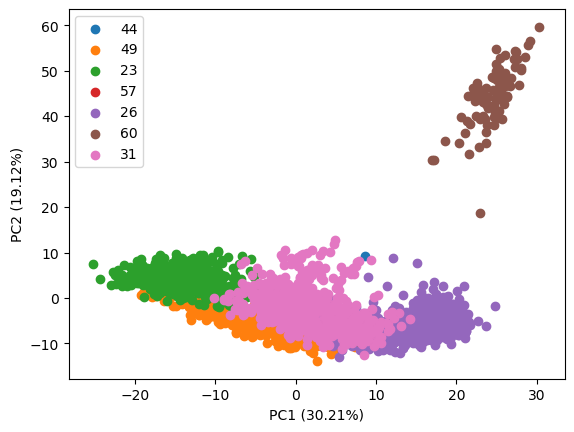

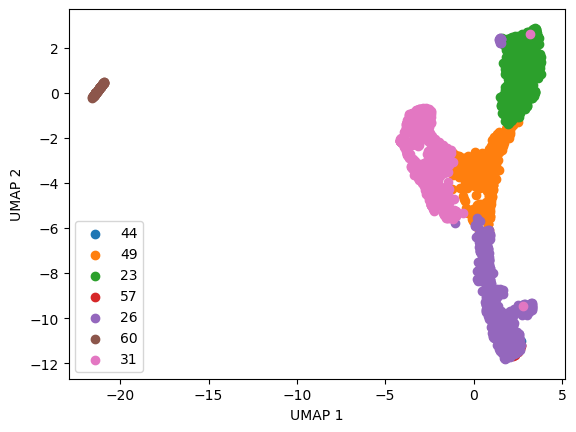

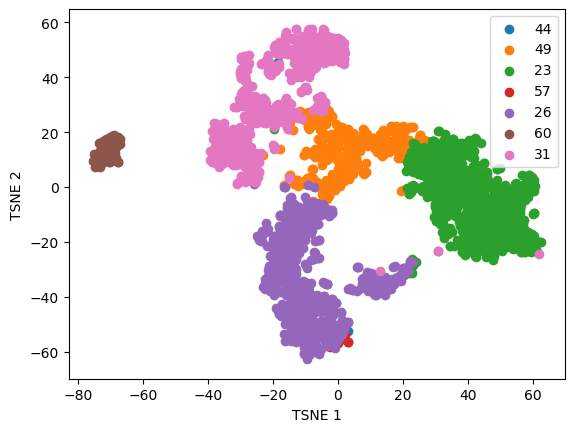

In [218]:
# Work with BCNN data, plotting by classes

colors = ['red','green','blue','maroon','magenta','lime','skyblue','darkgrey','black','gold','purple']
c = []
for i in range(1,1000):
    for j in range(1,len(colors)):
        c.append(colors[j])
colors = c
labels = ['']*len(unique_clusters)
for i,s in enumerate(unique_clusters):
    labels[i] = str(s)

# PCA
plt.figure(0)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(pcs[irx,0],pcs[irx,1])
plt.legend(labels)    
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)

# UMAP
plt.figure(1)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(umap_emb[irx,0],umap_emb[irx,1])
plt.legend(labels)    
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)

# TSNE
plt.figure(2)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1])
plt.legend(labels)    
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)

plt.show()



50 components are retained using factor 1000.00


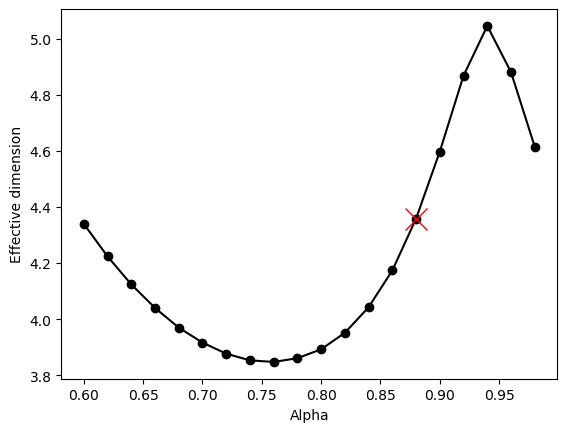

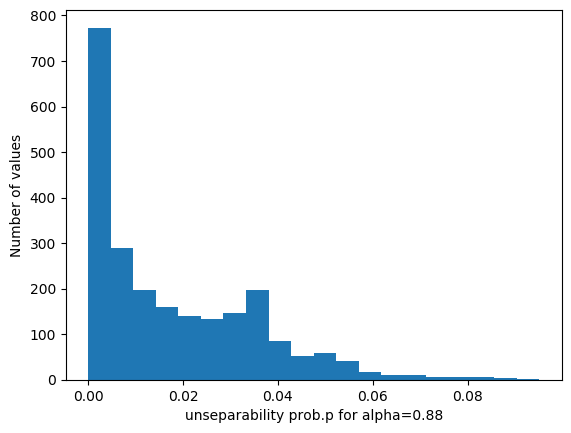

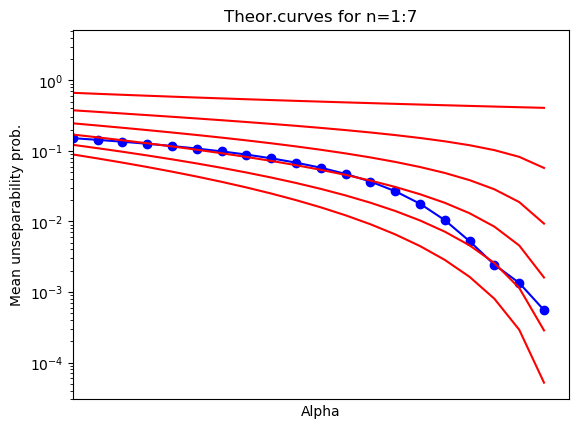

In [289]:
# separability analysis

[n_alpha,n_single,p_alpha,alphas,separable_fraction] = SeparabilityAnalysis(x.astype(np.float64),ColinearityControl=1000)

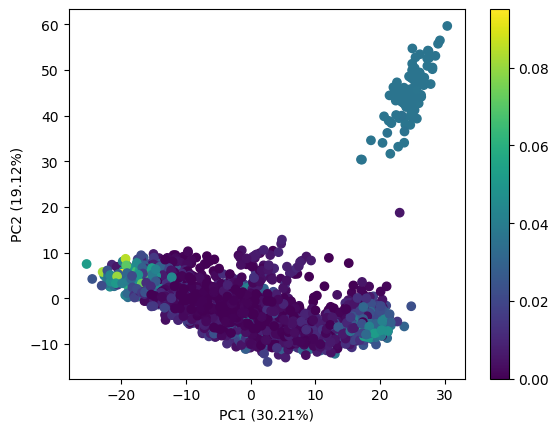

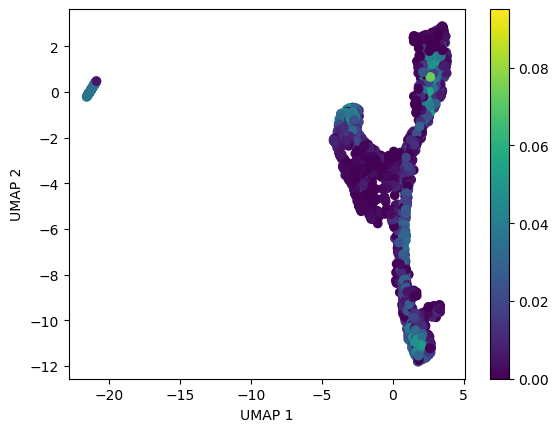

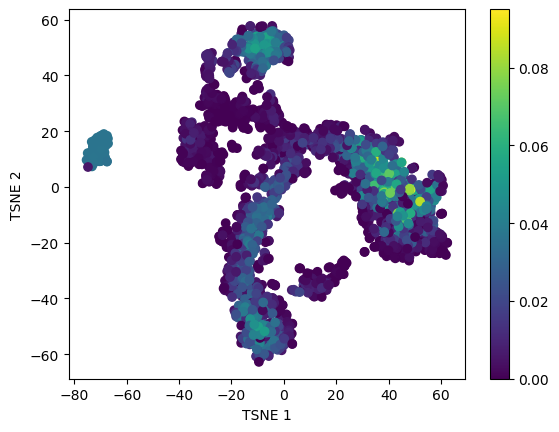

In [292]:
# plotting separability distribution

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*0
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]

c=p_alpha[alpha_index,irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()




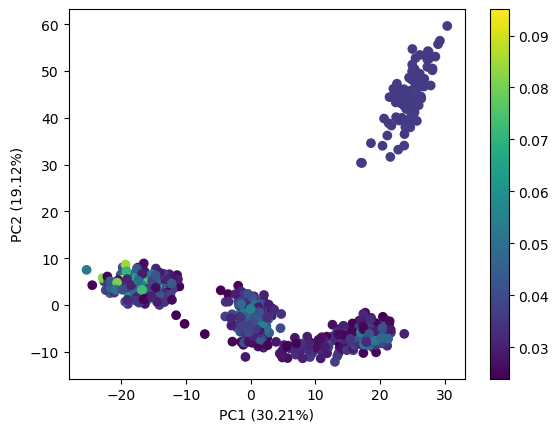

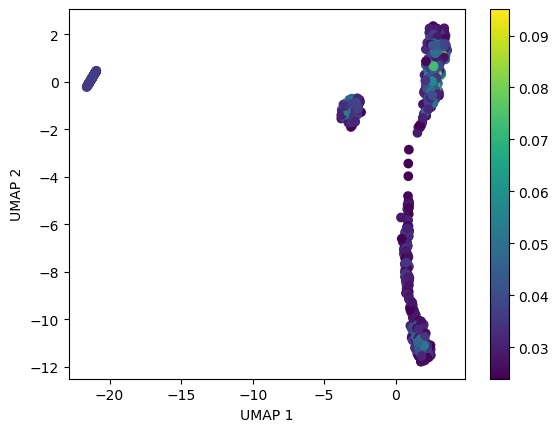

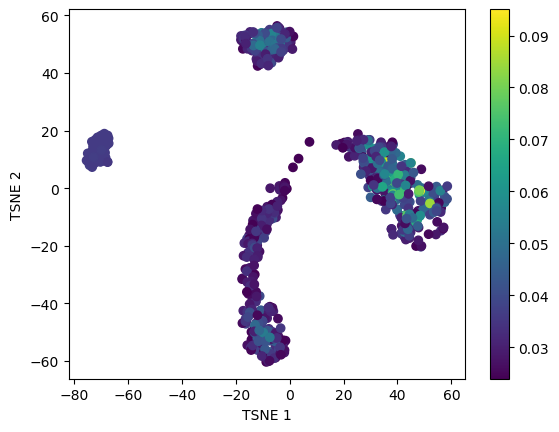

In [291]:
# plotting separability distribution

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*2
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]

c=p_alpha[alpha_index,irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()


In [293]:
# testing separability saturation

n_samples = x.shape[0]
print('Number of sample = {}'.format(n_samples))

sample_sizes = [1,2,5,10,20,30,40,50,100]
n_repeats = 20

dim_estimates = np.empty([len(sample_sizes),n_repeats])
print(dim_estimates)

for i,sz in enumerate(sample_sizes):
    sample_size = int(n_samples*sz/100)
    print('Sample size = {}'.format(sample_size))
    for j in range(0,n_repeats):
        sample = np.random.randint(0,n_samples,size=sample_size)
        xs = x[sample,:]
        [n_alpha_s,n_single_s,p_alpha_s,alphas_s,separable_fraction_s] = SeparabilityAnalysis(xs.astype(np.float64),ColinearityControl=1000,ProducePlots=False)
        print(n_single_s.astype(np.float64))
        dim_estimates[i,j] = n_single_s.astype(np.float64)
 
print(dim_estimates)


Number of sample = 2335
[[4.9627238  6.20373628 4.38697138 4.60923011 3.87627176 3.24833001
  3.59074312 4.9627238  3.59074312 3.68354302 4.81028326 4.81028326
  3.8909246  4.14800843 3.8909246  4.27646515 3.4226241  4.49360564
  5.68683318 3.87627176]
 [4.00448163 4.62552135 3.98654614 4.61957684 3.67995978 4.17923099
  4.41232023 4.79374217 4.28972518 4.28972518 3.82254698 4.18652525
  4.41232023 4.12783435 4.38697138 4.47901873 4.89428099 4.30942992
  4.41232023 4.99104022]
 [4.81778093 4.65526429 4.97341938 4.54699357 4.24278687 4.1538931
  4.39679504 3.85768943 4.44817361 4.39679504 4.37688244 4.61801513
  4.13783814 4.14583666 4.17018301 4.64271182 4.63029639 4.28229283
  4.37553246 4.30058345]
 [4.49021266 4.55133831 4.18219009 4.28324497 4.28775454 4.34571022
  4.28775454 4.32449962 4.49563505 4.27651448 3.98666179 4.23265029
  4.2609656  4.10669352 4.340962   4.75053419 4.28549749 4.36248884
  4.07637843 4.44254816]
 [4.5323437  4.34417374 4.34772793 4.30010184 4.27981528 4.39

[4.15923488]
Sample size = 700
48 components are retained using factor 1000.00
[4.40541723]
49 components are retained using factor 1000.00
[4.35912821]
50 components are retained using factor 1000.00
[4.30116287]
49 components are retained using factor 1000.00
[4.34060845]
50 components are retained using factor 1000.00
[4.30166965]
49 components are retained using factor 1000.00
[4.50230334]
49 components are retained using factor 1000.00
[4.26845825]
50 components are retained using factor 1000.00
[4.31210947]
49 components are retained using factor 1000.00
[4.1912248]
49 components are retained using factor 1000.00
[4.18595628]
50 components are retained using factor 1000.00
[4.35300941]
50 components are retained using factor 1000.00
[4.26600052]
50 components are retained using factor 1000.00
[4.54804272]
50 components are retained using factor 1000.00
[4.21536335]
50 components are retained using factor 1000.00
[4.37606102]
50 components are retained using factor 1000.00
[4.3577

(9, 20)
(9,)


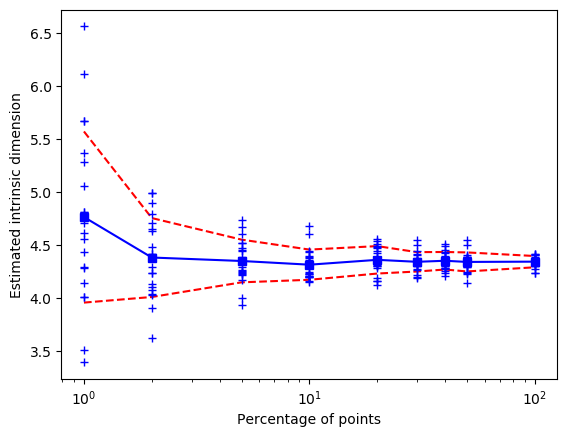

In [296]:
# plot convergence curve

print(dim_estimates.shape)

print(np.mean(dim_estimates[:,:],1).shape)
mn = np.mean(dim_estimates[:,:],1)
std = np.std(dim_estimates[:,:],1)

plt.figure(0)
plt.semilogx(sample_sizes,mn,'bs-')
plt.semilogx(sample_sizes,mn-std,'r--')
plt.semilogx(sample_sizes,mn+std,'r--')
plt.semilogx(sample_sizes,dim_estimates,'b+')
plt.xlabel('Percentage of points')
plt.ylabel('Estimated intrinsic dimension')
plt.show()


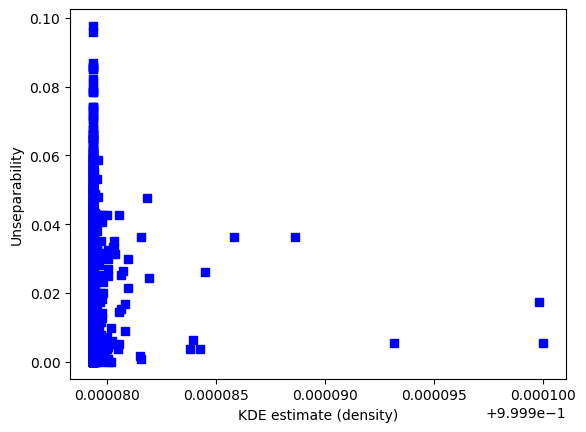

In [285]:
# compare separability with KDE density estimate

mu=np.array([1,10,20])
sigma=np.matrix([[4,10,0],[10,25,0],[0,0,100]])
data=np.random.multivariate_normal(mu,sigma,1000)
values = data.T

values = x.T
values = values.astype(np.float64)

kde = stats.gaussian_kde(values)
density = kde(values)
density = density/np.max(density)

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

plt.figure(0)
plt.plot(density,palpha_selected,'bs')
plt.xlabel('KDE estimate (density)')
plt.ylabel('Unseparability')
plt.show()


